# Active Portfolio Management

We'll start the project by importing necessary packages. 

In [99]:
# import necessary packages
import yfinance as yf
import requests
import pandas as pd
# for random selection of tickers
import random
import numpy as np
# for beta regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
# for alphas
import statsmodels.api as sm
# for quadratic program
import cvxpy as cp
# for graphing
import matplotlib.pyplot as plt
# get rid of warnings, they are annoying
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

After this, we'll access S&P 500 data. Namely, the S&P returns and the returns of all of the stocks within the S&P. Thanks to this, we won't have to use an outside data set to find stocks.

In [86]:
# access S&P 500 data
spx = yf.Ticker("^SPX")
spx = spx.history(period = '5y', interval = '1mo')

# scrape the top 500 stocks fom stockanalysis.com
page = requests.get('https://stockanalysis.com/list/sp-500-stocks/')
data = pd.read_html(page.content)[0]
tickers = list(data.Symbol)

## Finding the Right Stocks
Next, we'll create a function that can determine if each stock meets the criteria listed in the assignment. Namely:
- The stock has at least 5 years of historic monthly data
- The stock has a market cap of 2 billion
- The stock has a colume average of at least 20 million

To save some time, we'll only select 50 stocks from this list. It's a crapshoot after all, right?

In [87]:
def get_qualified_stocks(ticker_list):
    qualified_stocks = []

    for ticker in ticker_list:
        try:
            stock = yf.Ticker(ticker)
            
            # Check historical data for 5 years of monthly data
            history = stock.history(period="5y", interval="1mo")
            if len(history) < 60:  # 5 years * 12 months
                continue
            
            # Check market cap and average volume
            info = stock.info
            market_cap = info['marketCap']
            avg_volume = info['averageVolume']
            ask = info['currentPrice']

            if market_cap >= 2000000000 and avg_volume * ask >= 20000000:
                qualified_stocks.append({
                    'Ticker': ticker,
                    'Market Cap': market_cap,
                    'Average Volume': avg_volume
                })
        except Exception as e:
            print(f"Error with ticker {ticker}: {e}")

    return pd.DataFrame(qualified_stocks)

# select only 50 stocks from the 500.
tickers = random.sample(tickers, 50)

# run get_qualified_stocks() to determine which out of the 100 are valid for our needs.
qualified_stock = get_qualified_stocks(tickers)
tickers = qualified_stock.Ticker

In [88]:
qualified_stock

,Ticker,Market Cap,Average Volume
0,COO,19776679936,1251447
1,STX,20748976128,2229142
2,AFL,58027679744,2147058
3,LYV,31239247872,2490146
4,WYNN,10408265728,3002501
5,ECL,69776777216,983803
6,SNPS,79336087552,1050138
7,DAL,41036648448,8544496
8,ABBV,308021329920,5796425
9,NI,17121454080,3414507


## Finding Betas, Alphas, and the Covariance Matrix
Now that we've identified a valid list of stocks, we're going to find each one of their respective betas and alphas compared to the S&P. First, we'll define a function that uses regression to find the beta and alpha of a stock against the S&P. Then, we'll run a for loop through all of our stocks and save the information in a list. Furthermore, we'll use the .cov() attribute to find the covariance matrix.

In [89]:
# retrieve the historic data of our stocks
stock_data = yf.download(list(qualified_stock.Ticker), period='5y', interval = '1mo')
# only get the closing price of each variable
stock_data = stock_data.Close
# add the spx closing prices
stock_data['spx'] = list(spx.Close)
# find the percent differences in each month, only use the first 36 (60 percent) of observations
diff = stock_data.pct_change().dropna().iloc[:36, :]
# numpy-fy the data
spx_changes = np.array(list(diff['spx'])).reshape(-1, 1)

# define a model variable
model = LinearRegression()


# ---------------------
# to find the betas 
# ---------------------

def beta(stock_list):
    # make the data for the stock changes
    changes = np.array(list(diff[stock_list])).reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(spx_changes, changes, test_size = 0.4)
    # run the regression
    output = model.fit(X_train, y_train)
    # return the alpha
    return output.coef_

# run a for loop and create a list with all betas
betas = [beta(i)for i in qualified_stock.Ticker]

# ---------------------
# to find the alphas
# ---------------------
def alpha(stock_list):
    X = sm.add_constant(diff['spx']) 
    model = sm.OLS(diff[stock_list], X).fit()
    beta = model.params['spx']
    return beta

alphas = np.array([alpha(i) for i in qualified_stock.Ticker])

# ---------------------
# to find the covariance
# ---------------------
covar = diff.iloc[:, :-1].cov()

[*********************100%***********************]  50 of 50 completed


## Optimizing a Portfolio
Now, we look to invest a portfolio. 

In [90]:
def long_only(betas, covariance):
    # grab the tickers
    tickers = qualified_stock.Ticker
    # reformat so that python doesn't get mad
    betass = np.array([i[0][0] for i in betas])
    # Portfolio weights
    weights = cp.Variable(len(tickers))  
    # define a max weight, can be changed
    max_weight = .15
    # define max risk, can be changed
    max_risk = .06


    # Constraints
    constraints = [
        weights >= 0,                    # Long-only
        cp.sum(weights) == 1,            # Weights sum to 1
        cp.sum(weights * betass) == 1,    # Portfolio beta equals 1
        cp.quad_form(weights, covariance) <= max_risk,  # Risk constraint
        cp.abs(weights) <= max_weight,
    ]

    # Objective function: Maximize alpha
    objective = cp.Maximize(weights @ alphas)

    # Problem definition
    problem = cp.Problem(objective, constraints)

    # Step 4: Solve the problem
    problem.solve()

    # round results, this is specific to the long only. 
    weights = [0 if i < 1e-5 else i for i in weights.value]

    # create a data frame with the tickers and their weights
    df = {'tickers': tickers, 'weights': weights}
    long_only_results = pd.DataFrame(df)
    # return a printable data frame and the weights 
    return long_only_results, weights

long_only_results = long_only(betas, covar)
long_only_results[0]

,tickers,weights
0,COO,0.000000
1,STX,0.000000
2,AFL,0.150000
3,LYV,0.000000
4,WYNN,0.000000
5,ECL,0.000000
6,SNPS,0.150000
7,DAL,0.150000
8,ABBV,0.000000
9,NI,0.000000


<Axes: >

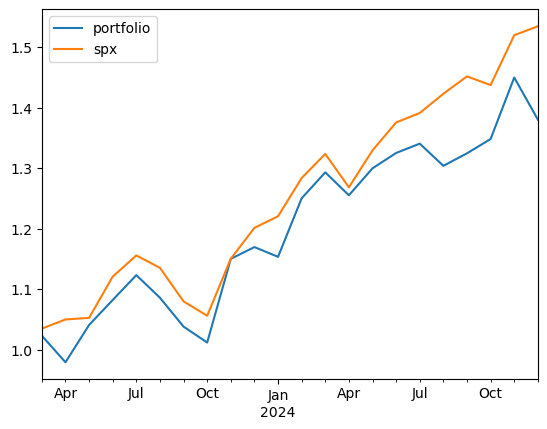

In [91]:
# Graph of the portfolio
weights = long_only_results[1]

# maybe you want to create your own weights? 
# your_weights = pd.DataFrame([tickers...], [data...])

def percent_increase(weights):
    # subset the testing data
    spx_test = stock_data.pct_change().dropna().iloc[37:]
    portfolio = pd.DataFrame(list(np.array(stock_data[tickers]) @ weights)[37:]).pct_change().dropna()
    #your_portfolio = pd.DataFrame(list(np.array(stock_data[tickers]) @ weights)[37:]).pct_change().dropna()
    # use these functions to determine the percentage change from the baseline
    i = 1
    j = 1
    k = 1
    # populate the lists with the changes per month 
    spx_trend = []
    portfolio_trend = []

    for l in spx_test.spx:
        if len(spx_trend) == 0:
            spx_trend.append(i * (1 + l))
        else:
            spx_trend.append(spx_trend[-1] * (1 + l))


    for l in portfolio.iloc[:, 0]:
        if len(portfolio_trend) == 0:
            portfolio_trend.append(j * (1 + l))
        else:
            portfolio_trend.append(portfolio_trend[-1] * (1 + l))
            
    for l in portfolio.iloc[:, 0]:
        if len(portfolio_trend) == 0:
            portfolio_trend.append(k * (1 + l))
        else:
            portfolio_trend.append(portfolio_trend[-1] * (1 + l))
    
    # create a data frame with the portolio and spx data 
    graph_compare = pd.DataFrame({'portfolio': portfolio_trend, 'spx': spx_trend}) # add your data too
    # add a datetime index 
    graph_compare.index = list(spx_test.index)
    return graph_compare


# plot the results 
percent_increase(weights).plot()

## For Long Short Portfolio

The only difference here is that we can remove the restraint that the weights must be greater than or equal to zero. 

In [94]:
def long_short(betas, covariance):
    # grab the tickers
    tickers = qualified_stock.Ticker
    # reformat so that python doesn't get mad
    betass = np.array([i[0][0] for i in betas])
    # Portfolio weights
    weights = cp.Variable(len(tickers))  
    # define a max weight, can be changed
    max_weight = .15
    # define max risk, can be changed
    max_risk = .07


    # Constraints
    constraints = [
        cp.sum(weights) == 1,            # Weights sum to 1
        cp.sum(weights * betass) == 1,    # Portfolio beta equals 1
        cp.quad_form(weights, covariance) <= max_risk,  # Risk constraint
        cp.abs(weights) <= max_weight,
    ]

    # Objective function: Maximize alpha
    objective = cp.Maximize(weights @ alphas)

    # Problem definition
    problem = cp.Problem(objective, constraints)

    # Step 4: Solve the problem
    problem.solve()

    # round results
    weights = [0 if abs(i) < 1e-5 else i for i in weights.value]

    df = {'tickers': tickers, 'weights': weights}
    long_short_results = pd.DataFrame(df)

    return long_short_results, weights

long_short_results = long_short(betas, covar)
long_short_results[0]

,tickers,weights
0,COO,-0.141877
1,STX,0.150000
2,AFL,0.150000
3,LYV,-0.058123
4,WYNN,0.150000
5,ECL,-0.150000
6,SNPS,0.150000
7,DAL,0.150000
8,ABBV,-0.150000
9,NI,-0.150000


<Axes: >

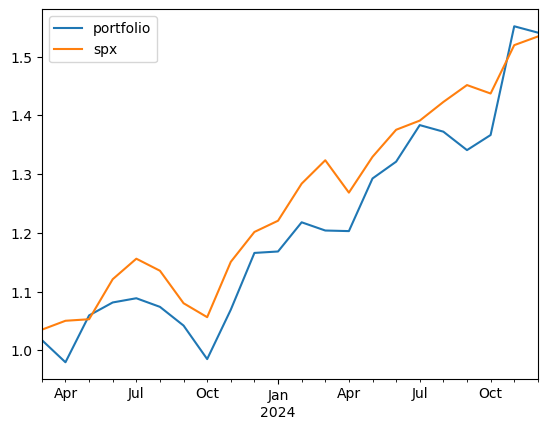

In [95]:
## Graph of Long Short Results
weights = long_short(betas, covar)[1]
# add your weights here!!!

percent_increase(weights).plot()

## Long Short 130/30 Split
Lastly, let's look at a long short 130/30 split. 

In [96]:
def long_short_balanced(betas, covariance):
    # grab the tickers
    tickers = qualified_stock.Ticker
    # reformat so that python doesn't get mad
    betass = np.array([i[0][0] for i in betas])
    # Portfolio weights
    weights = cp.Variable(len(tickers))  
    # define a max weight, can be changed
    max_weight = .20
    # define max risk, can be changed
    max_risk = .15

    long = cp.Variable(len(tickers), nonneg=True)  # Long positions (>= 0)
    short = cp.Variable(len(tickers), nonpos=True)


    # Constraints
    constraints = [
        cp.sum(weights) == 1,            # Weights sum to 1
        cp.sum(weights * betass) == 1,    # Portfolio beta equals 1
        cp.quad_form(weights, covariance) <= max_risk,  # Risk constraint
        cp.abs(weights) <= max_weight,
        weights == long + short,  # Decompose into long and short weights
        cp.sum(long) == 1.3,  # Total long exposure = 130%
        cp.sum(short) == -0.3,  # Total short exposure = -30%
    ]
    


    # Objective function: Maximize alpha
    objective = cp.Maximize(weights @ alphas)

    # Problem definition
    problem = cp.Problem(objective, constraints)

    # Step 4: Solve the problem
    problem.solve()

    # round results
    weights = [0 if abs(i) < 1e-5 else i for i in weights.value]

    df = {'tickers': tickers, 'weights': weights}
    long_short_split_results = pd.DataFrame(df)

    return long_short_split_results, weights

long_short_split_results = long_short_balanced(betas, covar)
long_short_split_results[0]

,tickers,weights
0,COO,0.000000
1,STX,0.000000
2,AFL,0.200000
3,LYV,0.000000
4,WYNN,0.000000
5,ECL,0.000000
6,SNPS,0.200000
7,DAL,0.200000
8,ABBV,-0.200000
9,NI,0.000000


<Axes: >

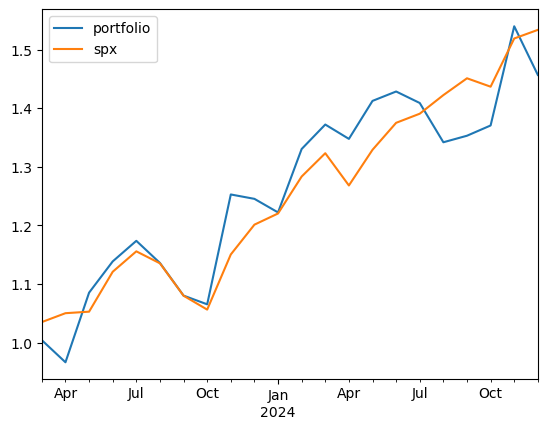

In [97]:
# Graph output of the portfolio
weights = long_short_balanced(betas, covar)[1]
# add your weights here!!!

percent_increase(weights).plot()

### Rolling Time Window

To do this, we'll actively update the betas, alphas, and covariance matrix at every quarter, and use this information to reinvest. 

<Axes: >

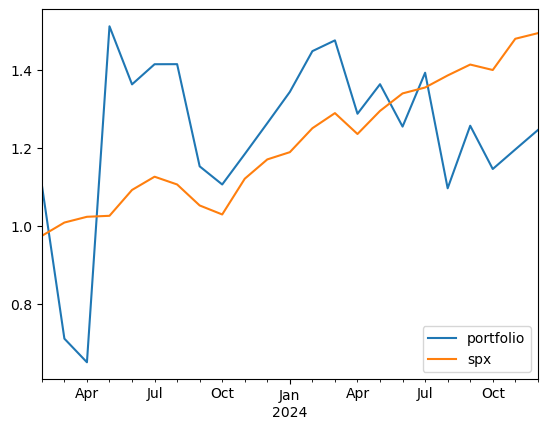

In [98]:
# find the percent differences in each month, only use the first 36 (60 percent) of observations
# This is a hardcode, since we set the start at 36 months
diff = stock_data.pct_change().dropna().iloc[:36, :]
# total amount of months
total_length = stock_data.shape[0]
# iterate through
i = 0
# results column
results = []

# while we are at the n-1th quarter
while diff.shape[0] <= total_length - 4:
    # find the percent differences in each month, only use the first 36 (60 percent) of observations
    diff = stock_data.pct_change().dropna().iloc[:36 + 4 * i, :]
    
    # numpy-fy the data
    spx_changes = np.array(list(diff['spx'])).reshape(-1, 1)
    
    # betas
    betas = [beta(i)for i in qualified_stock.Ticker]
    # ---------------------
    # to find the covariance
    # ---------------------
    covar = diff.iloc[:, :-1].cov()
    
    # ----------------------------
    # Choose from long_only, long_short, long_short_balanced
    # Type of portfolio to use, change as necessary
    # ----------------------------
    weights = long_short(betas, covar)[1] # HERE!!!!!!
    
    # Add the percent changes in the quarter
    portfolio = pd.DataFrame(list(np.array(stock_data[tickers]) @ weights)).pct_change().dropna()[36 + 4 * i: 36 + 4 * i + 4]
    results.append(list(portfolio.iloc[:, 0]))
    
    # duh
    i += 1
    
# unlist the nested values
unlisted_results = []

for i in results:
    for j in i:
        unlisted_results.append(j)
    
# create spx data as the benchmark
spx_test = stock_data.pct_change().dropna().iloc[36:]

# use these functions to determine the percentage change from the baseline
# Same as the code in previous function
i = 1
j = 1

spx_trend = []
portfolio_trend = []

for l in spx_test.spx:
    if len(spx_trend) == 0:
        spx_trend.append(i * (1 + l))
    else:
        spx_trend.append(spx_trend[-1] * (1 + l))


for l in unlisted_results:
    if len(portfolio_trend) == 0:
        portfolio_trend.append(j * (1 + l))
    else:
        portfolio_trend.append(portfolio_trend[-1] * (1 + l))

# set up final data frame comparing the portfolio to sp500
graph_compare = pd.DataFrame({'portfolio': portfolio_trend, 'spx': spx_trend})
graph_compare.index = list(spx_test.index)






# What happened? 
graph_compare.plot() 
    

## Discussion of Results
While this code is useful for choosing a (theoretically) efficient portfolio, we see a couple of notable results which should be mentioned as a cautionary note. For one, the option of stocks chosen for this portfolio was chosen completely at random. In the beginning, we chose 100 out of 500 S&P 500 stocks, so the possibiliities of portfolios are 500 choose 100, a massive number of 2e104. That is a larger number than pretty much anything tangible ever by a significant margin. You could sit here running and rerunning this code for millenia and never once get a matching portfolio. 

What does this mean? Even if you get a promising result on one roll of the dice, there's no saying that that's the expectation for this code in general. To find that number, you'd need to run this program a signficant number of times (definitely not 2e104, but probably at least 60-70 times) to get a good estimate of the baseline returns on long, long short, and long short balanced average and moving average portfolio optimizations. 

Furthermore, you can change the maximum weights of stocks to invest in and the risk of your portfolio. With all of these parameters to fiddle with, you'd need to run more tests in order to optimize these as well, something that doesn't happen here. 

Thirdly, the S&P saw an extremely bullish year for our testing data set. A 50% increase! While some of the models beat this upon random selection, this huge jump might inflate the real results of this model on off years. 


### Optional: Print Out Results

Run this cell for download of the covariance matrix, ticker's alphas and betas, and weights of each portfolio. 

In [ ]:
# alphas_betas = pd.DataFrame({'tickers': tickers, 'alphas': alphas, 'betas': betas})
# covar.to_csv('covar.csv')
# long_only_results.to_csv('long_only.csv')
# long_short_results.to_csv('long_short.csv')
# long_short_split_results.to_csv('130_30.csv')
# graph_compare.to_csv('rolling_window.csv')